# Imports

In [34]:
# Utility
import pandas as pd
import numpy as np
import joblib

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Reading and Analyzing data

In [16]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [91]:
df.shape

(200, 7)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [18]:
df.drop(['CustomerID'], axis=1).describe(include='all')

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200,200.000000,200.000000,200.000000
unique,2,NaN,NaN,NaN
top,Female,NaN,NaN,NaN
freq,112,NaN,NaN,NaN
mean,NaN,38.850000,60.560000,50.200000
std,NaN,13.969007,26.264721,25.823522
min,NaN,18.000000,15.000000,1.000000
25%,NaN,28.750000,41.500000,34.750000
50%,NaN,36.000000,61.500000,50.000000
75%,NaN,49.000000,78.000000,73.000000


### Replace Object data types with Numeric

In [19]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

### Corelation between Columns

In [22]:
df.drop(['CustomerID'], axis=1).corr()['Spending Score (1-100)'].sort_values().to_frame()

,Spending Score (1-100)
Age,-0.327227
Annual Income (k$),0.009903
Gender,0.058109
Spending Score (1-100),1.000000


# Visualization

### Age VS Spending

(0.0, 103.9)

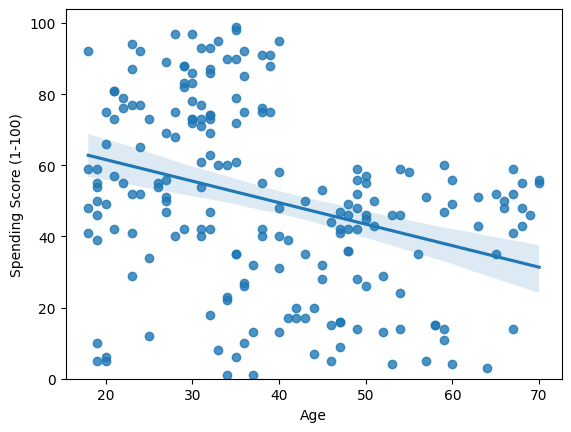

In [25]:
sns.regplot(x="Age", y="Spending Score (1-100)", data=df)
plt.ylim(0,)

In [28]:
# Binning the Age feature
df['Age_Bin'] = pd.cut(df['Age'], bins=[18, 30, 45, 70], labels=["Young", "Middle-aged", "Senior"])
df[['Age', 'Age_Bin', 'Spending Score (1-100)']].head(10)

,Age,Age_Bin,Spending Score (1-100)
0,19,Young,39
1,21,Young,81
2,20,Young,6
3,23,Young,77
4,31,Middle-aged,40
5,22,Young,76
6,35,Middle-aged,6
7,23,Young,94
8,64,Senior,3
9,30,Young,72


In [29]:
mean_spending = df.groupby('Age_Bin')['Spending Score (1-100)'].mean()
mean_spending

C:\Users\mohamed mowina\AppData\Local\Temp\ipykernel_34764\578800981.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_spending = df.groupby('Age_Bin')['Spending Score (1-100)'].mean()


Age_Bin
Young          61.103448
Middle-aged    52.569444
Senior         37.439394
Name: Spending Score (1-100), dtype: float64

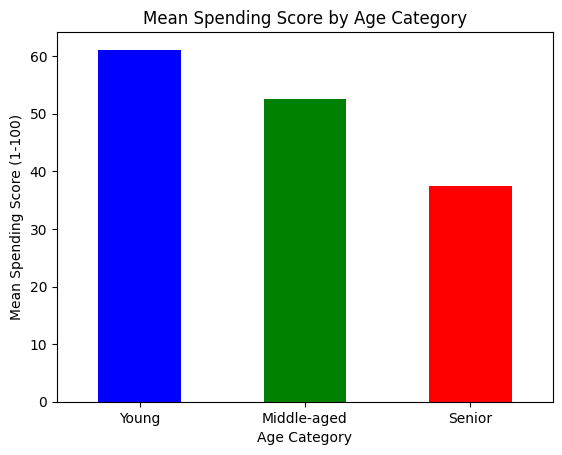

In [31]:
mean_spending.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Mean Spending Score by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Mean Spending Score (1-100)')
plt.xticks(rotation=0)
plt.show()

In [45]:
gender_groups = df.groupby('Gender')['Spending Score (1-100)'].mean()
print(gender_groups)

Gender
0    48.511364
1    51.526786
Name: Spending Score (1-100), dtype: float64


### Gender VS Spending

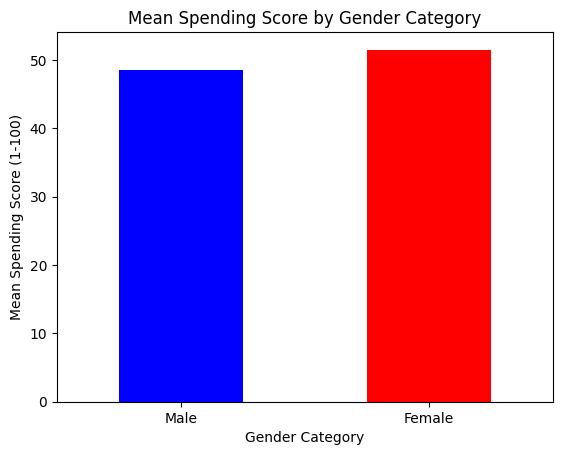

In [46]:
gender_groups.plot(kind='bar', color=['blue', 'red'])
plt.title('Mean Spending Score by Gender Category')
plt.xlabel('Gender Category')
plt.xticks([0, 1], ['Male', 'Female'], rotation=0)
plt.ylabel('Mean Spending Score (1-100)')
plt.show()

### Income VS Spending

Text(0, 0.5, 'Spending Score')

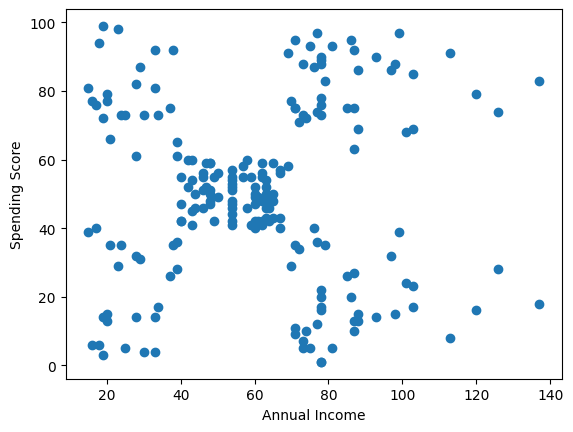

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'])
ax.set_xlabel('Annual Income')
ax.set_ylabel('Spending Score')

### Income Vs Age VS Spending

C:\Users\mohamed mowina\AppData\Local\Temp\ipykernel_34764\3783690530.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], cmap='rainbow')


(0.0, 143.1)

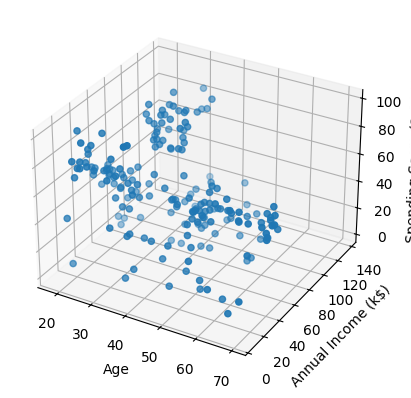

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], cmap='rainbow')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.ylim(0,)


# Model Development

In [50]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)', 'Age_Bin'],
      dtype='object')

### Elbow Method

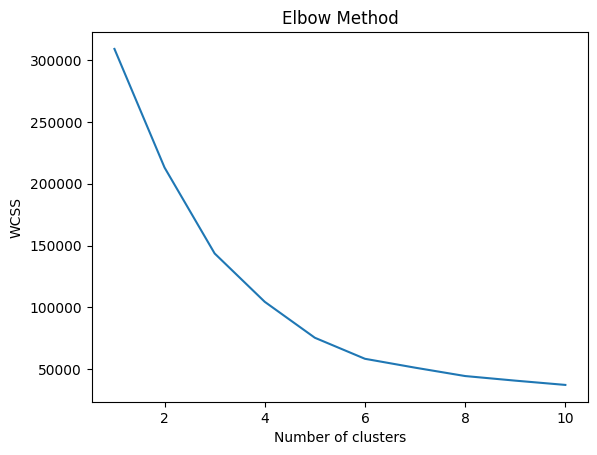

In [82]:
# Select features for clustering
X = df.drop(['CustomerID', 'Age_Bin', 'Gender'], axis=1)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()




In [83]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

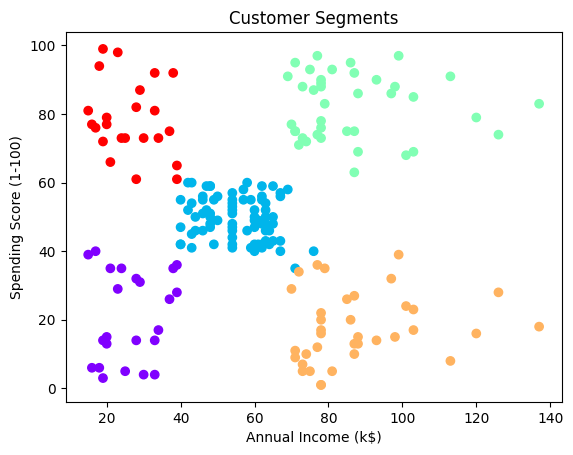

In [84]:
# Visualize the clusters
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['Cluster'], cmap='rainbow')
plt.title('Customer Segments')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

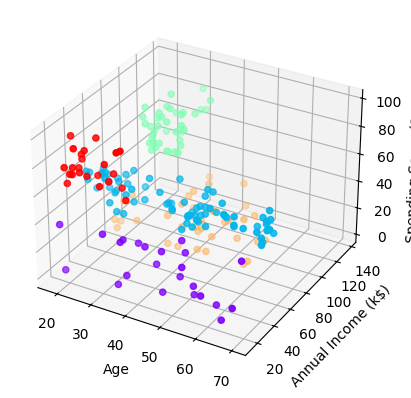

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['Cluster'], cmap='rainbow')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()


# Model Implementation

In [92]:
# Save Model
joblib.dump(kmeans,'Customers_Kmeans.joblib')

['Customers_Kmeans.joblib']

In [75]:
def classify_customer(name):
    input_dic = {
        'Gender': input('Enter Gender (0 for male , 1 for female): '),
        'Age': input('Enter Age: '),
        'Annual Income (k$)': input('Enter Income: '),
        'Spending Score (1-100)': input('Enter Spending Score: '),
        }
    print(input_dic)

    inputs = pd.DataFrame(input_dic, index=[0])
    prediction = kmeans.predict(inputs)
    print(f'Customer {name} Pelongs to Cluster: {prediction}')

In [76]:
classify_customer('Ahmed')

{'Gender': '0', 'Age': '25', 'Annual Income (k$)': '25000', 'Spending Score (1-100)': '5000'}
Customer Ahmed Pelongs to Cluster: [2]
